# STAT 207 Project 03 - Asteroid Modeling Project

Victor Liu and Shawn Zhang

## 1. Introduction

For this project I am using the same dataset (https://www.kaggle.com/datasets/sakhawat18/asteroid-dataset) from Kaggle that I used in the first and second STAT 207 project containing information regarding numerous asteroids in the solar system that have been discovered by astronomers all over the world. The original data is officially maintained by the Jet Propulsion Laboratory of California Institute of Technology, an organization under NASA, on its database search engine (https://ssd.jpl.nasa.gov/tools/sbdb_query.html) and has been transferred to Kaggle by an astronomy and astrophysics researcher. The Kaggle dataset is generally updated weekly as a result of new information/data gathered regarding any of the asteroids listed so there are numerous versions of the dataset that have been made and will be made in the future. As of the start of this project (4/15/2024), I'm using Version 194 of the data.

Astronomers and astrophysicists would definitely find this dataset useful for doing any research about the various characteristics of asteroids in general, or at least just the ones that have been catalogued. As mentioned in my previous projects, these results could be used by astronomers and astrophysicists to better determine and identify potentially hazardous asteroids in the future and warn authorities if necessary. Analysis could be done to find relationship between the many variables listed in the dataset and used to further our understanding of asteroids in the solar system. The dataset could also be used to train different models as to predict certain characteristics of newly discovered asteroids given specific parameters. The reason why I'm using this dataset is because I'm interested in astronomy. 

Some research questions that I want to answer are:

- What is the relationship between absolute magnitude (H) and Earth MOID (moid) after controlling for eccentricity (e), perihelion distance (q), and semi-major axis length (a)? How does my model perform on new data?
- Is there a linear relationship between the log odds of an asteroid being potentially hazardous (pha) and absolute magnitude (H), eccentricity (e), and Earth MOID (moid) in the sample? How does a classifier built on this model perform on new data?

The answers to these questions can help astronomers and astrophysicists better identify characteristics of potentially hazardous asteroids as new asteroids are cataloged and information about previously discovered asteroids is updated. The models created in the process of answering these questions could also potentially be used on additional data outside this dataset as more and more asteroids are discovered. The answers could also help humanity better understand some of our astronomical neighbors that exist within the solar system.

I'll briefly explain what each variable means before diving into the analysis so it's easier to understand my research question and results. Briefly explaining what an astronomical unit means, 1 AU is the average distance between the Earth and the Sun which is about 93 million miles or about 150 million kilometers. Continuing on, absolute magnitude is a value that an observer would record if the asteroid was placed 1 AU away from the Earth and the sun at a zero phase angle, or an angle which all three objects exist on the same line (Sun and Earth would overlap in space). This is important because the absolute magnitude allows astronomers to compare the inherent brightness of objects regardless of their actual distance from Earth. Asteroids, among other celestial objects, don't produce their own light and instead reflect light. How well an asteroid reflects light should depend on its size and how pale it is. The less light reflected, the greater the value, the more light reflected, the smaller the value. The absolute value can be negative but among asteroids that's fairly uncommon. This absolute magnitude scale is specific to smaller celestial bodies such as asteroids and planets as other larger celestial and deep space objects have their own absolute magnitude scale that uses the same idea but with larger numbers. Orbital eccentricity is how circular or elliptical an asteroid's orbit is. An e of 0 means the orbit is a perfect circle, between 0 and 1 means the orbit is elliptical, at 1 the orbit actually becomes an escape trajectory that is parabolic, and greater than 1 means that the escape trajectory is hyperbolic. The perihelion is the point in an object's orbit in which it is closest to sun so the perihelion distance would just be a quantitative measure of how far the object is from the Sun at that point. The minimum orbit intersection distance is the distance between the closest points of the osculating orbits (orbit if there isn't anything influencing either orbit) of two bodies. The moid in this case is specifically the earth moid because we want to know the closest an asteroid can get to earth so that we can determine if its potentially hazardous or not. The semi major axis length is the longest radius of an ellipse, so in this case, the longest radius of an objects orbit. In simpler terms, it is the distance from the center of an asteroid's orbit to the furthest edge of its orbit.

In [2]:
#Imports here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

sns.set(rc={'figure.figsize':(25, 10)})
pd.set_option('display.max_columns', None)

## 2. Linear Regression Analytical Tasks

To state the research questions again, I want to know what the relationship is between absolute magnitude (H) and Earth MOID (moid) after controlling for eccentricity (e), perihelion distance (q), and semi-major axis length (a) as well as how the model performs on new data.

Before I answer those questions I'll quickly clean up the dataset for modeling.

In [3]:
asteroid = pd.read_csv("asteroids.csv", low_memory=False)
asteroid.head(10)

,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,albedo,diameter_sigma,orbit_id,epoch,epoch_mjd,epoch_cal,equinox,e,a,q,i,om,w,ma,ad,n,tp,tp_cal,per,per_y,moid,moid_ld,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0000001,2000001,1 Ceres,1,Ceres,NaN,N,N,3.40,939.400,0.0900,0.200,JPL 47,2458600.5,58600,20190427.0,J2000,0.076009,2.769165,2.558684,10.594067,80.305531,73.597695,77.372098,2.979647,0.213885,2.458239e+06,2.018043e+07,1683.145703,4.608202,1.594780,620.640533,4.819000e-12,1.032800e-11,1.956900e-11,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,a0000002,2000002,2 Pallas,2,Pallas,NaN,N,N,4.20,545.000,0.1010,18.000,JPL 37,2459000.5,59000,20200531.0,J2000,0.229972,2.773841,2.135935,34.832932,173.024741,310.202392,144.975675,3.411748,0.213345,2.458321e+06,2.018072e+07,1687.410992,4.619880,1.234290,480.348639,3.193400e-08,4.033700e-09,8.832200e-08,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,a0000003,2000003,3 Juno,3,Juno,NaN,N,N,5.33,246.596,0.2140,10.594,JPL 112,2459000.5,59000,20200531.0,J2000,0.256936,2.668285,1.982706,12.991043,169.851482,248.066193,125.435355,3.353865,0.226129,2.458446e+06,2.018112e+07,1592.013769,4.358696,1.034290,402.514639,3.052000e-08,3.471800e-09,8.139200e-08,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,a0000004,2000004,4 Vesta,4,Vesta,NaN,N,N,3.00,525.400,0.4228,0.200,JPL 35,2458600.5,58600,20190427.0,J2000,0.088721,2.361418,2.151909,7.141771,103.810804,150.728541,95.861938,2.570926,0.271609,2.458248e+06,2.018051e+07,1325.432763,3.628837,1.139480,443.451432,2.332100e-10,1.514300e-09,1.928600e-09,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,a0000005,2000005,5 Astraea,5,Astraea,NaN,N,N,6.90,106.699,0.2740,3.140,JPL 114,2459000.5,59000,20200531.0,J2000,0.190913,2.574037,2.082619,5.367427,141.571026,358.648418,17.846343,3.065455,0.238661,2.458926e+06,2.020032e+07,1508.414421,4.129814,1.095750,426.433027,2.373700e-08,3.970900e-09,6.092400e-08,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191
5,a0000006,2000006,6 Hebe,6,Hebe,NaN,N,N,5.80,185.180,0.2679,2.900,JPL 89,2459000.5,59000,20200531.0,J2000,0.203219,2.424533,1.931822,14.739653,138.643432,239.736273,190.686496,2.917243,0.261073,2.459649e+06,2.022031e+07,1378.924506,3.775290,0.973673,378.924321,1.978600e-08,2.748200e-09,4.811900e-08,2.191800e-06,1.122100e-05,1.300600e-05,7.392200e-06,3.306700e-09,4.438800e-10,2.875400e-05,2.344500e-06,MBA,0.41032
6,a0000007,2000007,7 Iris,7,Iris,NaN,N,N,5.60,199.830,0.2766,10.000,110,2459000.5,59000,20200531.0,J2000,0.230145,2.387375,1.837933,5.521598,259.563943,145.201545,247.425811,2.936818,0.267192,2.459422e+06,2.021073e+07,1347.347071,3.688835,0.850693,331.064195,1.991900e-08,2.007500e-09,4.748800e-08,2.582500e-06,2.641200e-05,2.707500e-05,7.014700e-06,2.469500e-09,3.370100e-10,2.662700e-05,1.699400e-06,MBA,0.38128
7,a0000008,2000008,8 Flora,8,Flora,NaN,N,N,6.50,147.491,0.2260,1.025,JPL 118,2459000.5,59000,20200531.0,J2000,0.155833,2.201415,1.858362,5.889081,110.876524,285.458915,315.318013,2.544467,0.301753,2.459149e+06,2.020103e+07,1193.029574,3.266337,0.875980,340.905137,2.364400e-08,2.308400e-09,5.176000e-08,3.240300e-06,2.432000e-05,2.664600e-05,1.209200e-05,2.668100e-09,4.746200e-10,4.018700e-05,1.876500e-06,MBA,0.54186
8,a0000009,2000009,9 Metis,9,Metis,NaN,N,N,6.30,190.000,0.1180,NaN,JPL 116,2459000.5,59000,20200531.0,J2000,0.123300,2.386189,2.091972,5.576494,68.909459,6.337325,23.912204,2.680407,0.267391,2.458911e+06,2.020030e+07,1346.343282,3.686087,1.107110,430.853999,1.841400e-08,3.089300e-09,4.425800e-08,2.007400e-06,2.417000e-05,2.600800e-05,1.036600e-05,3.470200e-09,5.192700e-10,

In [4]:
len(asteroid)

958524

I'll first put the variables we'll be using for analysis in one dataset to simplify the analysis. Then I'll check for missing values in those variables and drop them.

In [5]:
asteroid = asteroid[["pha", "H", "e", "a", "q", "moid"]]
asteroid.isna().sum()

pha     19921
H        6263
e           0
a           0
q           0
moid    19921
dtype: int64

In [6]:
asteroid_clean = asteroid.dropna(subset=["pha", "H"])


In [7]:
len(asteroid_clean)

932341

I dropped 26,183 missing values because they make up only 2.731% of the total sample of 958,524. I do not think that dropping them will greatly impact the results or validity of my models.

For the data, I'm not too concerned as to whether the data is accurate or not. As mentioned before, since the original dataset is maintained and curated by JPL, I don't expect there to be many errors. I'll remove any observations with potential errors or any extreme outliers that are far different from the rest of the observations as one of the assumptions for logistic modeling are that there aren't any extreme outliers.

Text(0.5, 1.0, 'Histogram of Earth MOIDs in Astronomical Units')

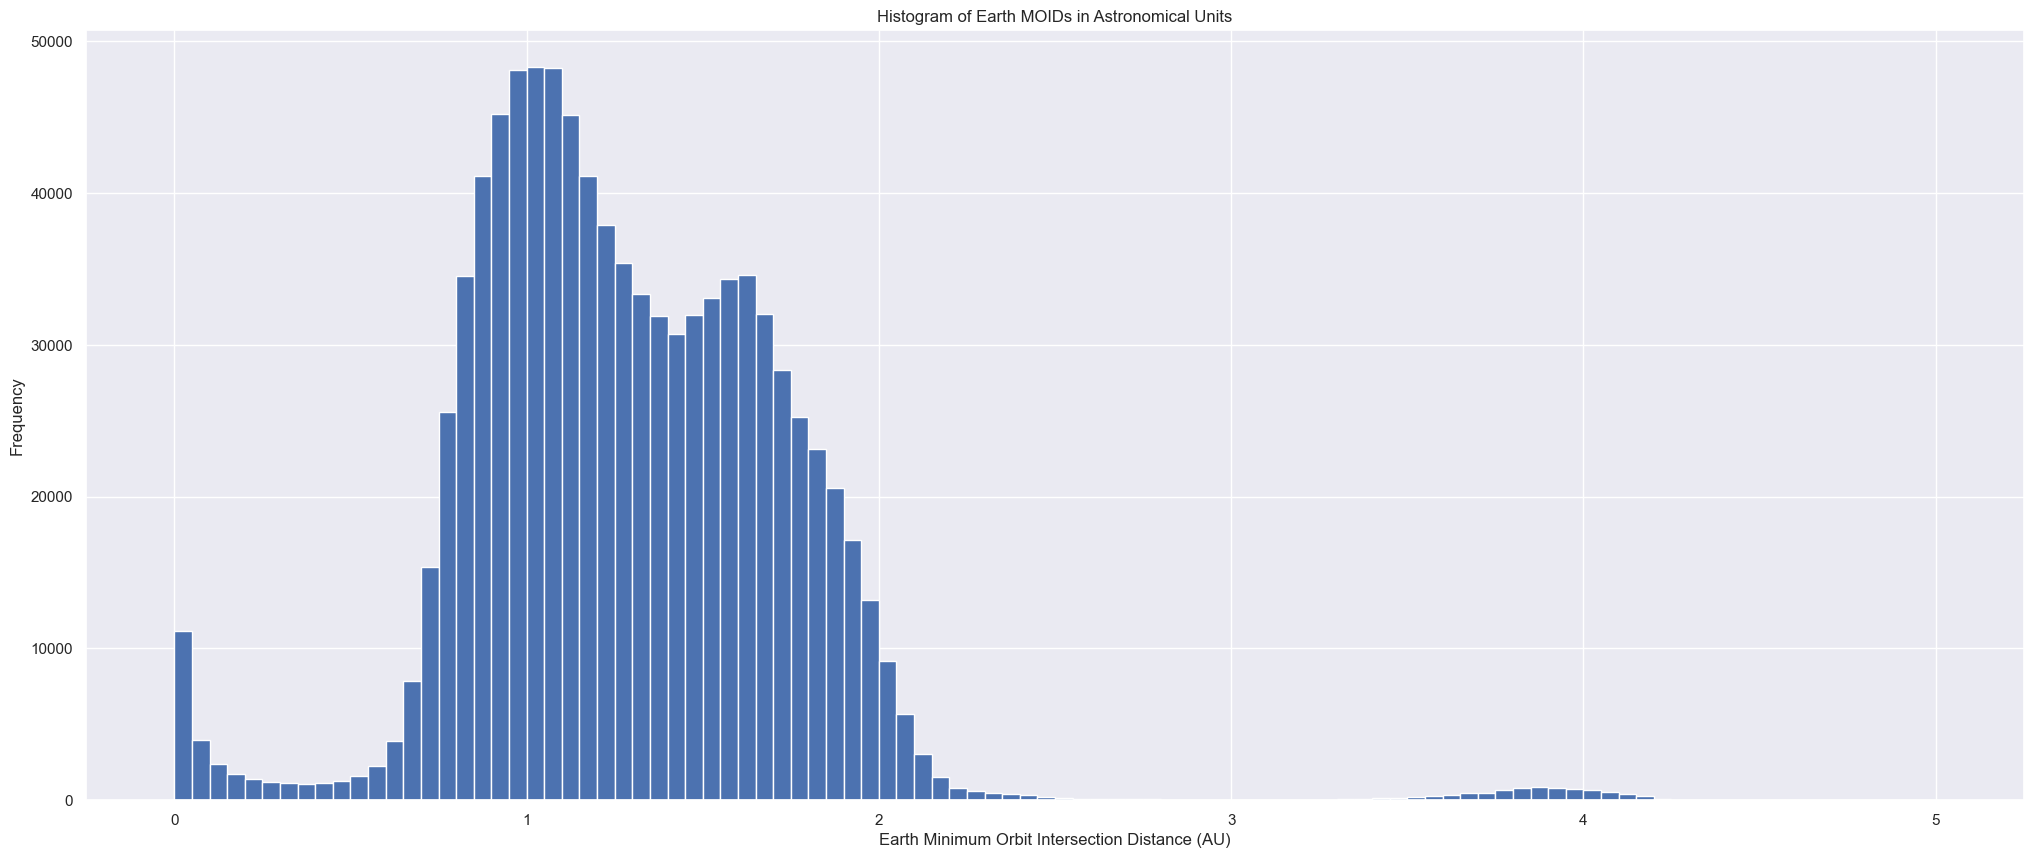

In [8]:
asteroid_clean["moid"].hist(bins=100, range = [0, 5])
plt.xlabel("Earth Minimum Orbit Intersection Distance (AU)")
plt.ylabel("Frequency")
plt.title("Histogram of Earth MOIDs in Astronomical Units")

In [9]:
asteroid_clean[asteroid_clean["moid"] > 3].shape

(11848, 6)

In [10]:
drop1 = asteroid_clean["moid"] > 3
asteroid_clean = asteroid_clean[~drop1]

Text(0.5, 1.0, 'Histogram of Orbital Eccentricity')

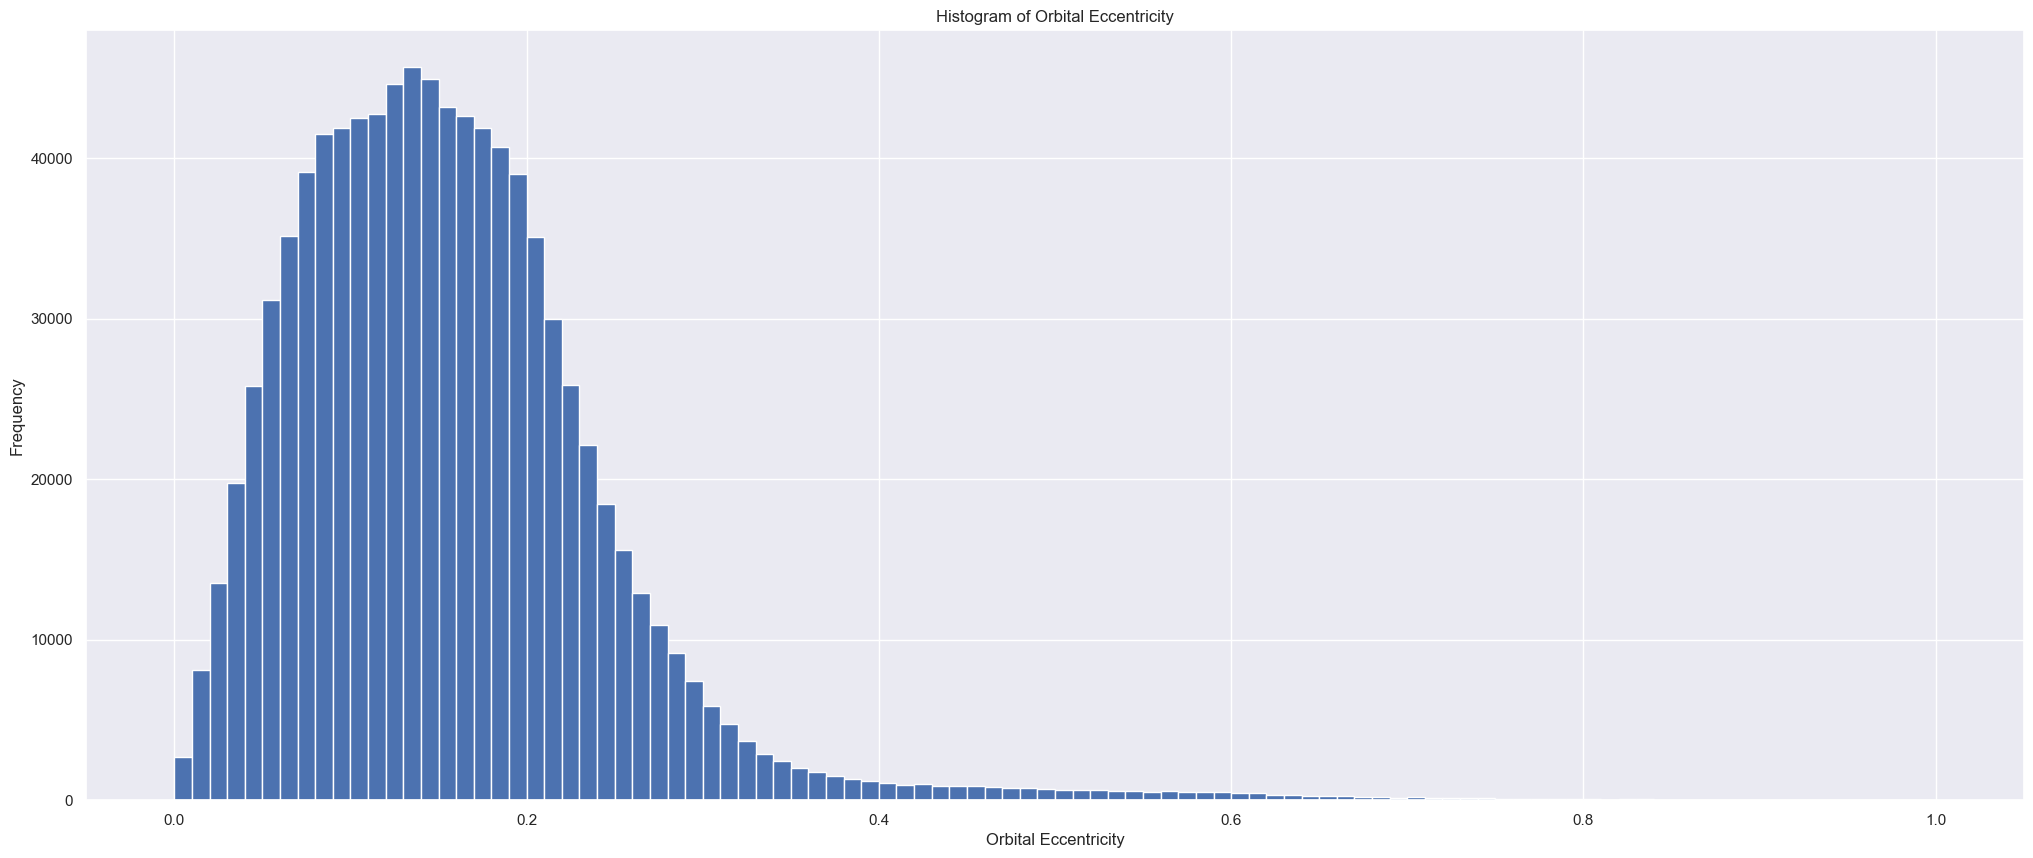

In [11]:
asteroid_clean["e"].hist(bins=100, range = [0, 1])
plt.xlabel("Orbital Eccentricity")
plt.ylabel("Frequency")
plt.title("Histogram of Orbital Eccentricity")

In [12]:
asteroid_clean[asteroid_clean["e"] > 1].shape

(1, 6)

In [13]:
drop2 = asteroid_clean["e"] > 1
asteroid_clean = asteroid_clean[~drop2]

Text(0.5, 1.0, 'Histogram of Asteroid Absolute Magnitude (H)')

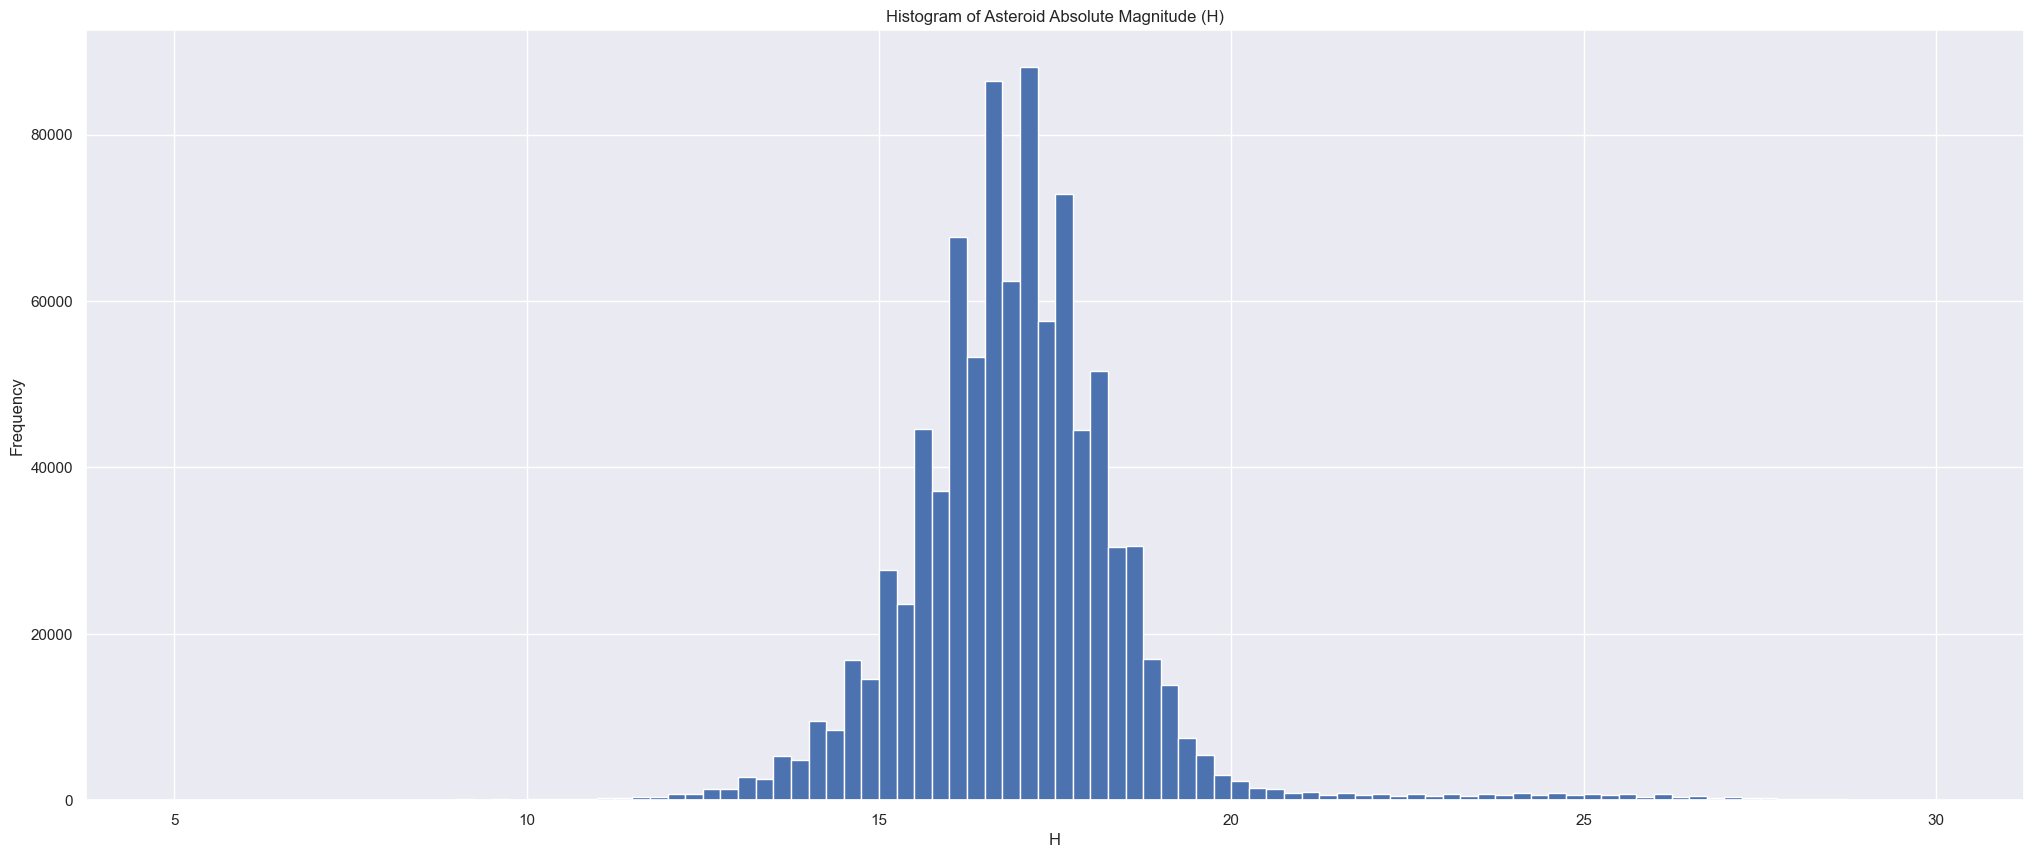

In [14]:
asteroid_clean["H"].hist(bins=100, range=[5,30])
plt.xlabel("H")
plt.ylabel("Frequency")
plt.title("Histogram of Asteroid Absolute Magnitude (H)")

In [15]:
asteroid_clean[(asteroid_clean["H"] < 5) | (asteroid_clean["H"] > 30)].shape

(59, 6)

In [16]:
drop3 = (asteroid_clean["H"] < 5) | (asteroid_clean["H"] > 30)
asteroid_clean = asteroid_clean[~drop3]

Text(0.5, 1.0, 'Histogram of Perihelion Distance in Astronomical Units')

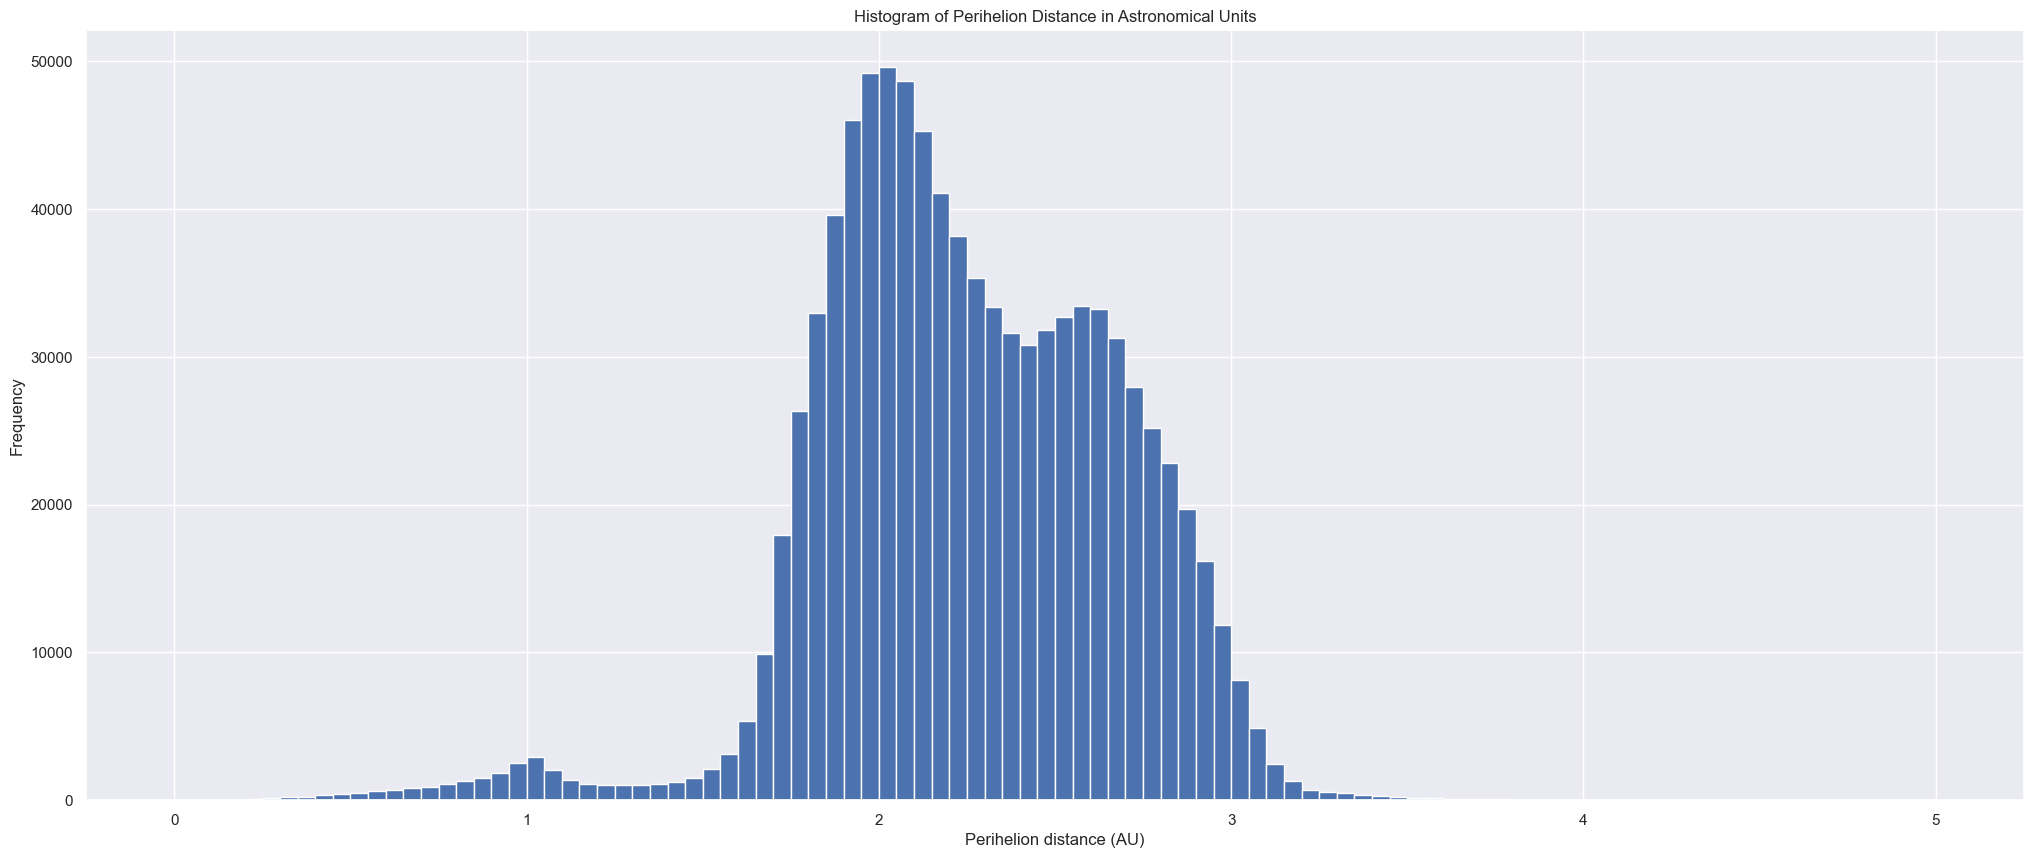

In [17]:
asteroid_clean["q"].hist(bins=100, range=[0, 5])
plt.xlabel("Perihelion distance (AU)")
plt.ylabel("Frequency")
plt.title("Histogram of Perihelion Distance in Astronomical Units")

Text(0.5, 1.0, 'Histogram of Semi-Major Axis Length in Astronomical Units')

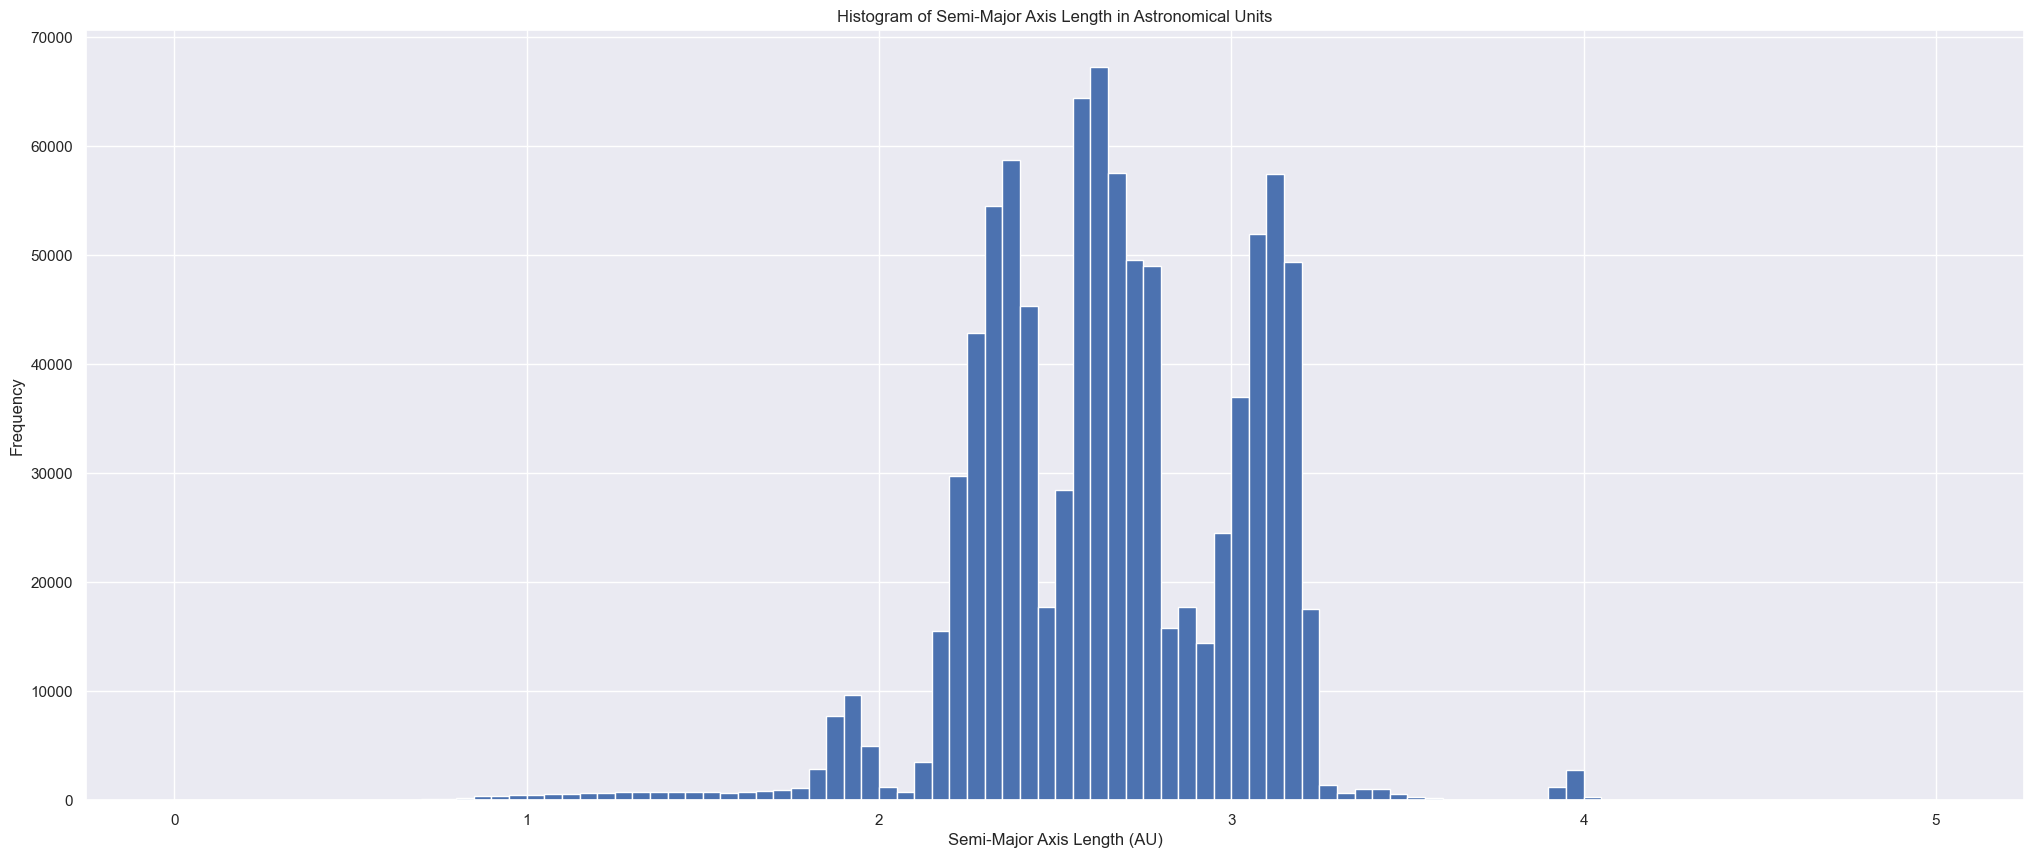

In [18]:
asteroid_clean["a"].hist(bins=100, range=[0, 5])
plt.xlabel("Semi-Major Axis Length (AU)")
plt.ylabel("Frequency")
plt.title("Histogram of Semi-Major Axis Length in Astronomical Units")

In [19]:
asteroid_clean[asteroid_clean["a"] > 5].shape

(272, 6)

In [20]:
drop4 = asteroid_clean["a"] > 5
asteroid_clean = asteroid_clean[~drop4]

After looking for uncommon values in the data using the histogram above, I removed an additional 12,179 observations, which is 1.378% of the dataset left after the first wave of data cleaning. Specifically, 11,848 of the observations dropped were ones with moids greater than 3 astronomical units because they seemed to lie above the majority of the data. I removed one observation with an orbital eccentricity greater than 1 which didn't make much sense. I also removed 59 observations with absolute magnitudes either less than 5 or greater than 30 since those values were far from the rest of the values on the histogram. Another 271 of the observations dropped were ones with semi-major axis length's greater than 5 astronomical units as they were above the majority of the data shown in the histogram. No observations with a specific perihelion distance were removed as it seems any outliers that I planned to remove had already been removed when dropping earlier observations. Even though some of the remaining data may contain outliers for some variables, they're not as extreme as the one's already removed. Doing it this way, the models I create using this data can be better as assumptions for modeling will be met.

Here's the dataset after cleaning.

In [21]:
asteroid_clean

,pha,H,e,a,q,moid
2,N,5.330,0.256936,2.668285,1.982706,1.034290
4,N,6.900,0.190913,2.574037,2.082619,1.095750
5,N,5.800,0.203219,2.424533,1.931822,0.973673
6,N,5.600,0.230145,2.387375,1.837933,0.850693
7,N,6.500,0.155833,2.201415,1.858362,0.875980
...,...,...,...,...,...,...
958519,N,17.135,0.185919,2.280861,1.856807,0.861979
958520,N,18.500,0.282920,2.334910,1.674319,0.671242
958521,Y,20.400,0.662446,2.817152,0.950941,0.035589
958522,N,18.071,0.202053,2.373137,1.893638,0.893896


Before going any further, I'll split the data into a testing and training set with a test size of 20% and a random state of 100.

In [22]:
asteroid_train, asteroid_test = train_test_split(asteroid_clean, test_size = 0.2, random_state = 100)

Now I can start to answer the questions I asked.

I want to know what the relationship is between absolute magnitude (H) and Earth MOID (moid) after controlling for eccentricity (e), perihelion distance (q), and semi-major axis length (a) as well as how the model performs on new data.

Let's first fit the linear model, where H is the response variable and e, q, a, moid are the explanatory variables

In [23]:
X_train = sm.add_constant(asteroid_train[['e', 'q', 'a', 'moid']])
y_train = asteroid_train['H']
lm = sm.OLS(y_train, X_train).fit()

In [24]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      H   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                 1.117e+05
Date:                Tue, 23 Apr 2024   Prob (F-statistic):               0.00
Time:                        02:00:14   Log-Likelihood:            -1.2494e+06
No. Observations:              736128   AIC:                         2.499e+06
Df Residuals:                  736123   BIC:                         2.499e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.3744      0.049    353.251      0.000      17.278      17.471
e             18.3574      0.098    186.457      0.000      18.164      18.550
q              7.0911      0.064    110.144      0.000       6.965       7.217
a             -6.2316      0.031   -202.434      0.000      -6.292      -6.171
moid          -2.1132      0.039    -54.709      0.000      -2.189      -2.037
==============================================================================
Omnibus:                    80468.484   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           646096.172
Skew:                          -0.213   Prob(JB):                         0.00
Kurtosis:                       7.570   Cond. No.                         324.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Then we have the linear model equation:

    predicted H = 17.3744 + 18.3574*e + 7.0911*q + -6.2316*a + -2.1132*moid

To answer the first question, for every additional astronomical unit in moid, holding all other predictor variables constant, the predicted absolute magnitude of the asteroid is estimated to decrease by 2.1132 on average.

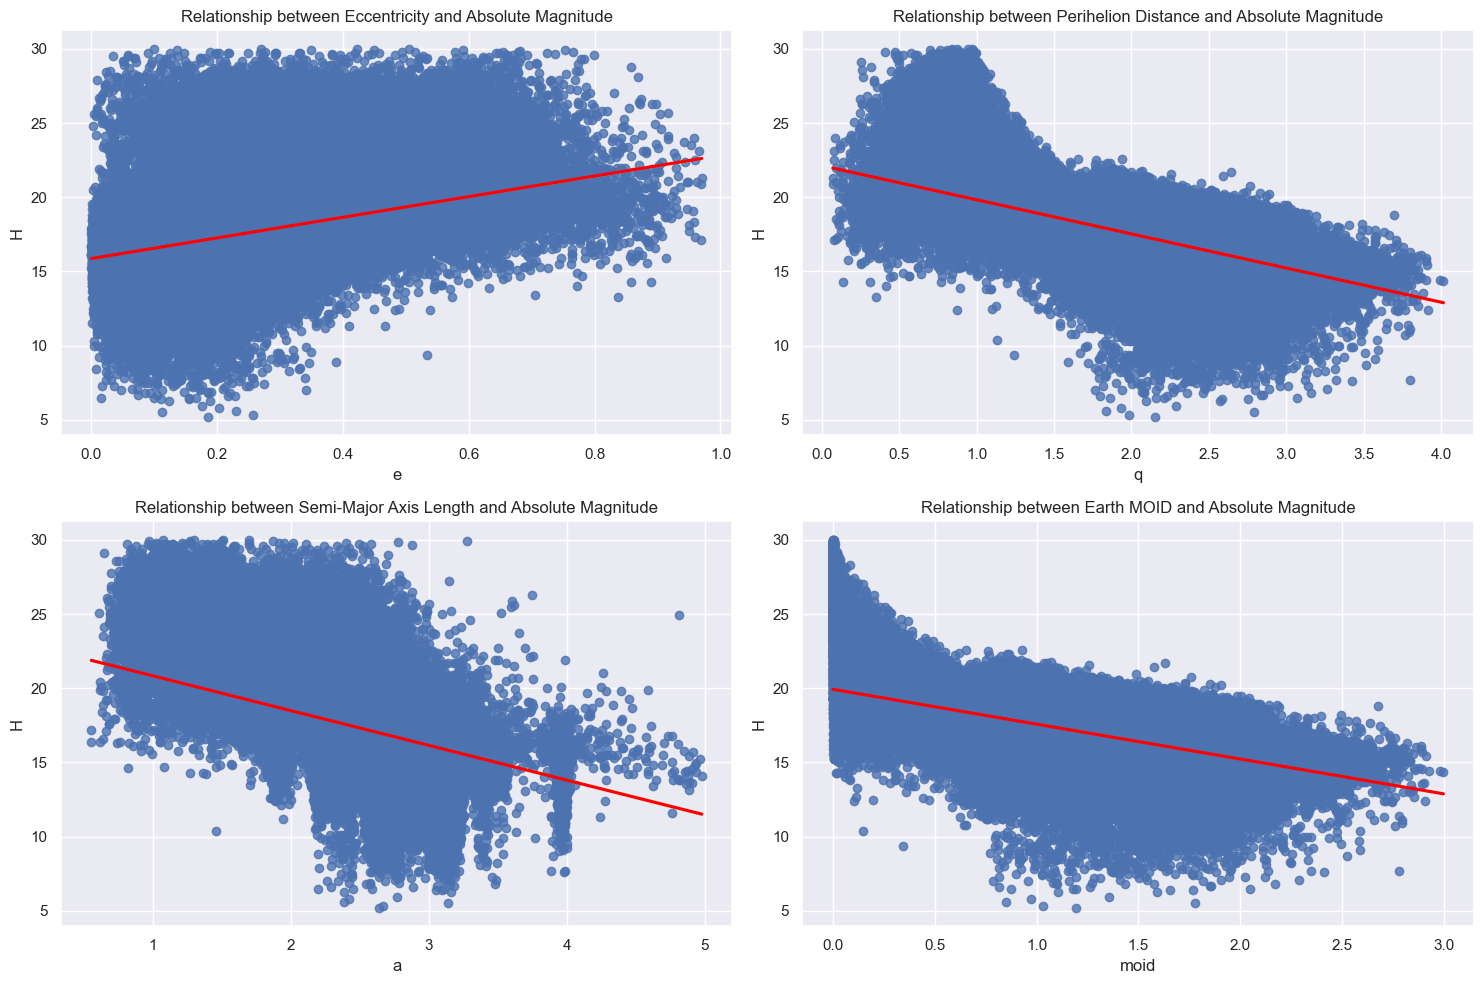

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

sns.regplot(x='e', y='H', data=asteroid_train, ax=axs[0, 0], line_kws={'color': 'red'})
axs[0, 0].set_title('Relationship between Eccentricity and Absolute Magnitude')

sns.regplot(x='q', y='H', data=asteroid_train, ax=axs[0, 1], line_kws={'color': 'red'})
axs[0, 1].set_title('Relationship between Perihelion Distance and Absolute Magnitude')

sns.regplot(x='a', y='H', data=asteroid_train, ax=axs[1, 0], line_kws={'color': 'red'})
axs[1, 0].set_title('Relationship between Semi-Major Axis Length and Absolute Magnitude')

sns.regplot(x='moid', y='H', data=asteroid_train, ax=axs[1, 1], line_kws={'color': 'red'})
axs[1, 1].set_title('Relationship between Earth MOID and Absolute Magnitude')

plt.tight_layout()
plt.show()

The model results indicate a significant relationship between the predictors and the absolute magnitude of asteroids. Specifically, the positive coefficients for eccentricity (e) and perihelion distance (q) suggest that as these variables increase, the absolute magnitude tends to increase, indicating that asteroids appear brighter. Conversely, the negative coefficients for semi-major axis length (a) and Earth MOID (moid) suggest that greater values of these variables are associated with a decrease in the absolute magnitude, implying a dimmer appearance of the asteroids.

Here we chose moid and calculate its coefficient and the 95% confidence interval:

In [55]:
slope_coefficient = lm.params['moid']
print(f"Slope Coefficient for moid: {slope_coefficient}")

confidence_interval = lm.conf_int(alpha=0.05).loc['moid']
print(f"95% Confidence Interval for Slope Coefficient of moid: {confidence_interval.iloc[0], confidence_interval.iloc[1]}")

Slope Coefficient for moid: -2.113179991222648
95% Confidence Interval for Slope Coefficient of moid: (-2.1888847810412617, -2.0374752014040345)


I am 95% confident that the true slope coefficient for the moid when trying to predict an asteroid's absolute magnitude is between -2.188 and -2.037.

Checking the linearity assumption.

In [56]:
train_predictions = lm.predict(X_train)

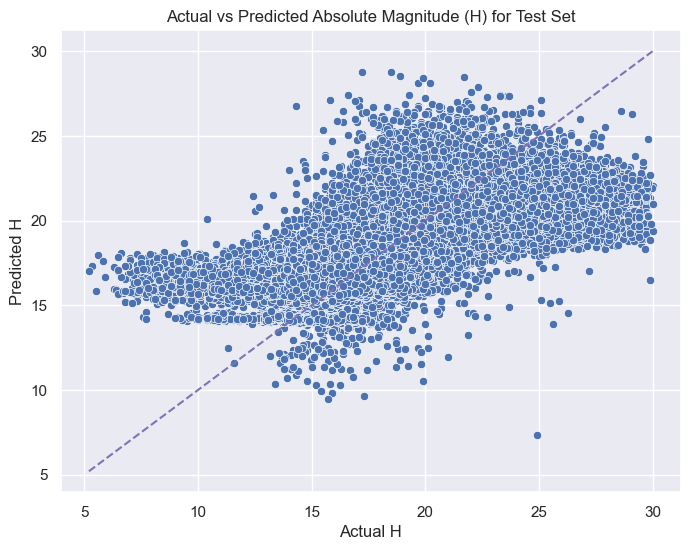

In [63]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_train, y=train_predictions)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'm--')
plt.xlabel('Actual H')
plt.ylabel('Predicted H')
plt.title('Actual vs Predicted Absolute Magnitude (H) for Test Set')
plt.show()

Visual assessments through scatterplots of actual vs. predicted H values and residual diagnostics further reinforce the model's adequacy.

The fitted vs. residuals plot tells a similar story as the residuals seem to be roughly randomly spread across the e = 0 line.

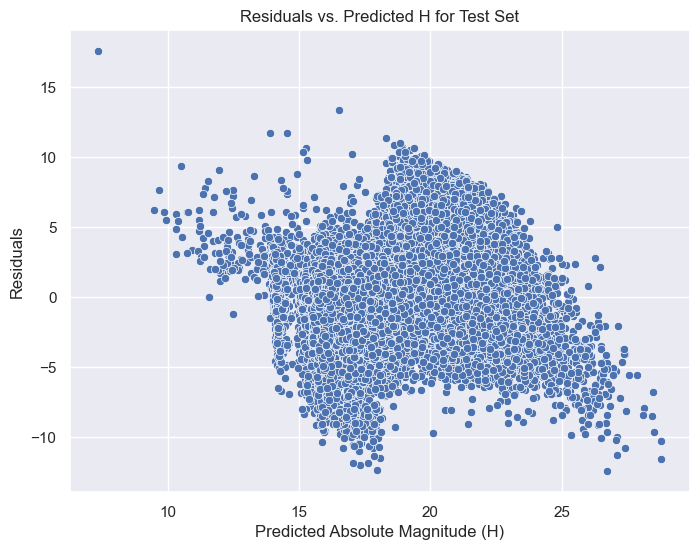

In [69]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=train_predictions, y=lm.resid)
plt.xlabel('Predicted Absolute Magnitude (H)')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted H for Test Set')
plt.show()

Checking for multicollinearity.

In [61]:
asteroid_train[["e", "q", "a", "moid"]].corr()

,e,q,a,moid
e,1.000000,-0.683881,-0.188587,-0.654944
q,-0.683881,1.000000,0.837086,0.993357
a,-0.188587,0.837086,1.000000,0.841327
moid,-0.654944,0.993357,0.841327,1.000000


Unfortunately there does seem to be very high multicollinearity between perihelion distance and moid and slightly less multicollinearity between moid and semi-major axis length as well as perihelion distance and semi-major axis length. Multicollinearity results in unreliable slope coefficients for the model created which we will have to acknowledge.

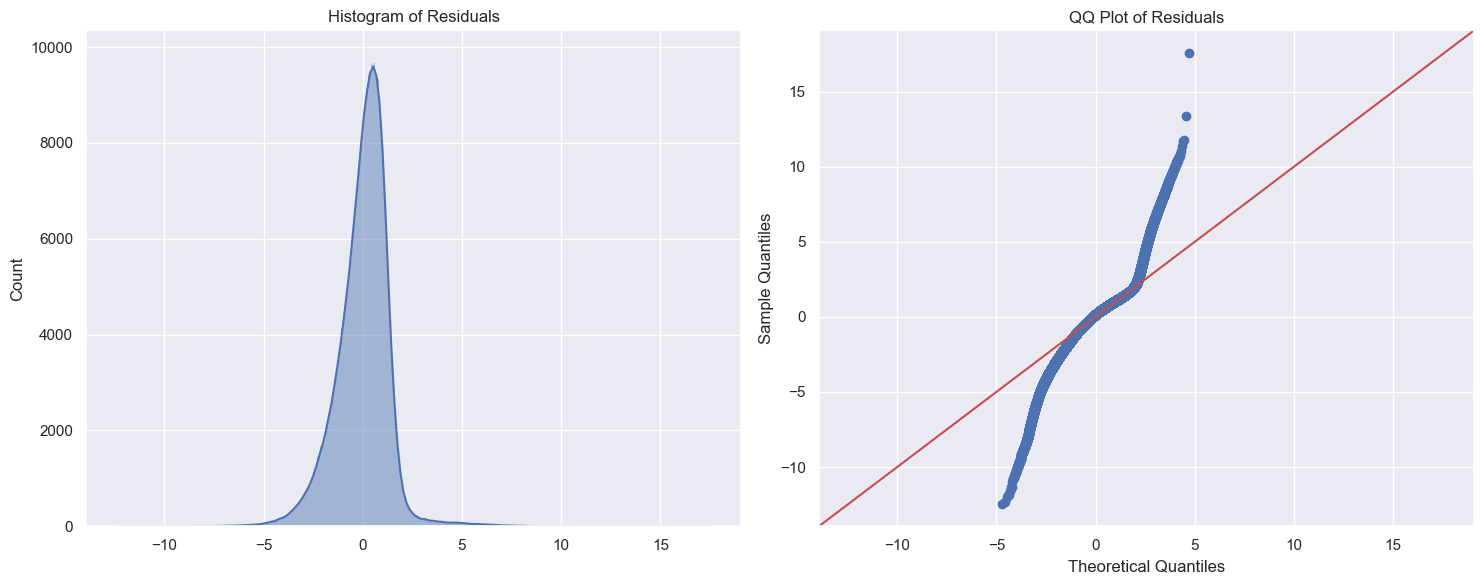

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(lm.resid, kde=True, ax=ax[0])
ax[0].set_title('Histogram of Residuals')

sm.qqplot(lm.resid, line='45', ax=ax[1])
ax[1].set_title('QQ Plot of Residuals')

plt.tight_layout()
plt.show()

Residual analyses, including the histogram and QQ plot, do not reveal any alarming deviations from normality, indicating that the model's assumptions are reasonably met.

To evaluate the model, we would consider the R-squared value:

In [27]:
r_squared = lm.rsquared
print(f"R-squared: {r_squared}")

R-squared: 0.37775913080698487


The R-squared value of approximately 0.378 signifies that around 37.8% of the variability in the absolute magnitude can be explained by the linear model, which is a considerable amount given the complexity of celestial measurements and the potential for unaccounted factors influencing asteroid brightness.

Then we would make a prediction using the first row of the dataset:

In [48]:
X_test = sm.add_constant(asteroid_test[['e', 'q', 'a', 'moid']])
y_test = asteroid_test['H']
test_predictions = lm.predict(X_test)

residual = y_test.iloc[0] - test_predictions.iloc[0]
print(f"Actual H: {y_test.iloc[0]}, Predicted H: {test_predictions.iloc[0]}, Residual: {residual}")

Actual H: 15.4, Predicted H: 17.463651527122344, Residual: -2.063651527122344


In [29]:
train_predictions = lm.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print(f"Training Data RMSE: {train_rmse}")
print(f"Testing Data RMSE: {test_rmse}")

Training Data RMSE: 1.3208824627290834
Testing Data RMSE: 1.323122585645615


Predictive performance on new data, assessed through the root mean square error (RMSE), shows a close correspondence between the observed and predicted values of H, with RMSE values of approximately 1.32 for both the training and testing datasets. This consistency underlines the model's robustness and its potential applicability in predicting the absolute magnitude of newly discovered asteroids or updating the attributes of known ones. The major setback to this model is the high multicollinearity which produces unreliable slope coefficients.

In short for this linear regression model, this model provides valuable insights into the factors influencing the absolute magnitude of asteroids despite the high multicollinearity. While the model demonstrates a good fit and predictive capability, there is an opportunity for further research, potentially by incorporating additional predictors, exploring non-linear relationships, or employing different modeling techniques to capture more of the variability in the data.

## 3. Logistic Regression Analytical Tasks

To state the research questions again, I want to know if there's a linear relationship between the log odds of an asteroid being potentially hazardous (pha) and absolute magnitude (H), eccentricity (e), and Earth MOID (moid) in the sample as well as how a classifier built on this model perform on new data.

Before going further, I'll split the data again with the same test size and random state for this section.

In [32]:
asteroid_train, asteroid_test = train_test_split(asteroid_clean, test_size = 0.2, random_state = 100)

To start, I'll fit a logistic regression model to the data by turning the pha status into a dummy variable and display a summary of the model as well.

In [33]:
asteroid_train["dummy_pha"] = asteroid_train["pha"].replace({"N":0, "Y":1})

In [34]:
asteroid_test["dummy_pha"] = asteroid_test["pha"].replace({"N":0, "Y":1})

In [35]:
model = smf.logit("dummy_pha ~ H + e + moid", data = asteroid_train).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.002196
         Iterations 19


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              dummy_pha   No. Observations:               736128
Model:                          Logit   Df Residuals:                   736124
Method:                           MLE   Df Model:                            3
Date:                Tue, 23 Apr 2024   Pseudo R-squ.:                  0.8615
Time:                        02:05:36   Log-Likelihood:                -1616.6
converged:                       True   LL-Null:                       -11671.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.1634      0.909     37.570      0.000      32.381      35.946
H             -1.4847      0.038    -39.482      0.000      -1.558      -1.411
e             -0.0662      0.262     -0.253      0.800      -0.579       0.446
moid        -105.9407      3.122    -33.935      0.000    -112.059     -99.822
==============================================================================

Possibly complete quasi-separation: A fraction 0.98 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

The larger the log odds, the larger the odds, and the larger the odds, the larger the probability of an asteroid being potentially hazardous. That would mean that a low absolute magnitude (H), orbital eccentricity (e), and moid are all associated with a higher probability of success because all of their slope coefficients are negative. The larger any of those variables are, the lower the probability that an asteroid is a potentially hazardous one.

To answer the first question, I'll create a fitted vs. deviance residuals plot to see if there's a linear relationship between the log odds of an asteroid being potentially hazardous and the three predictor variables.

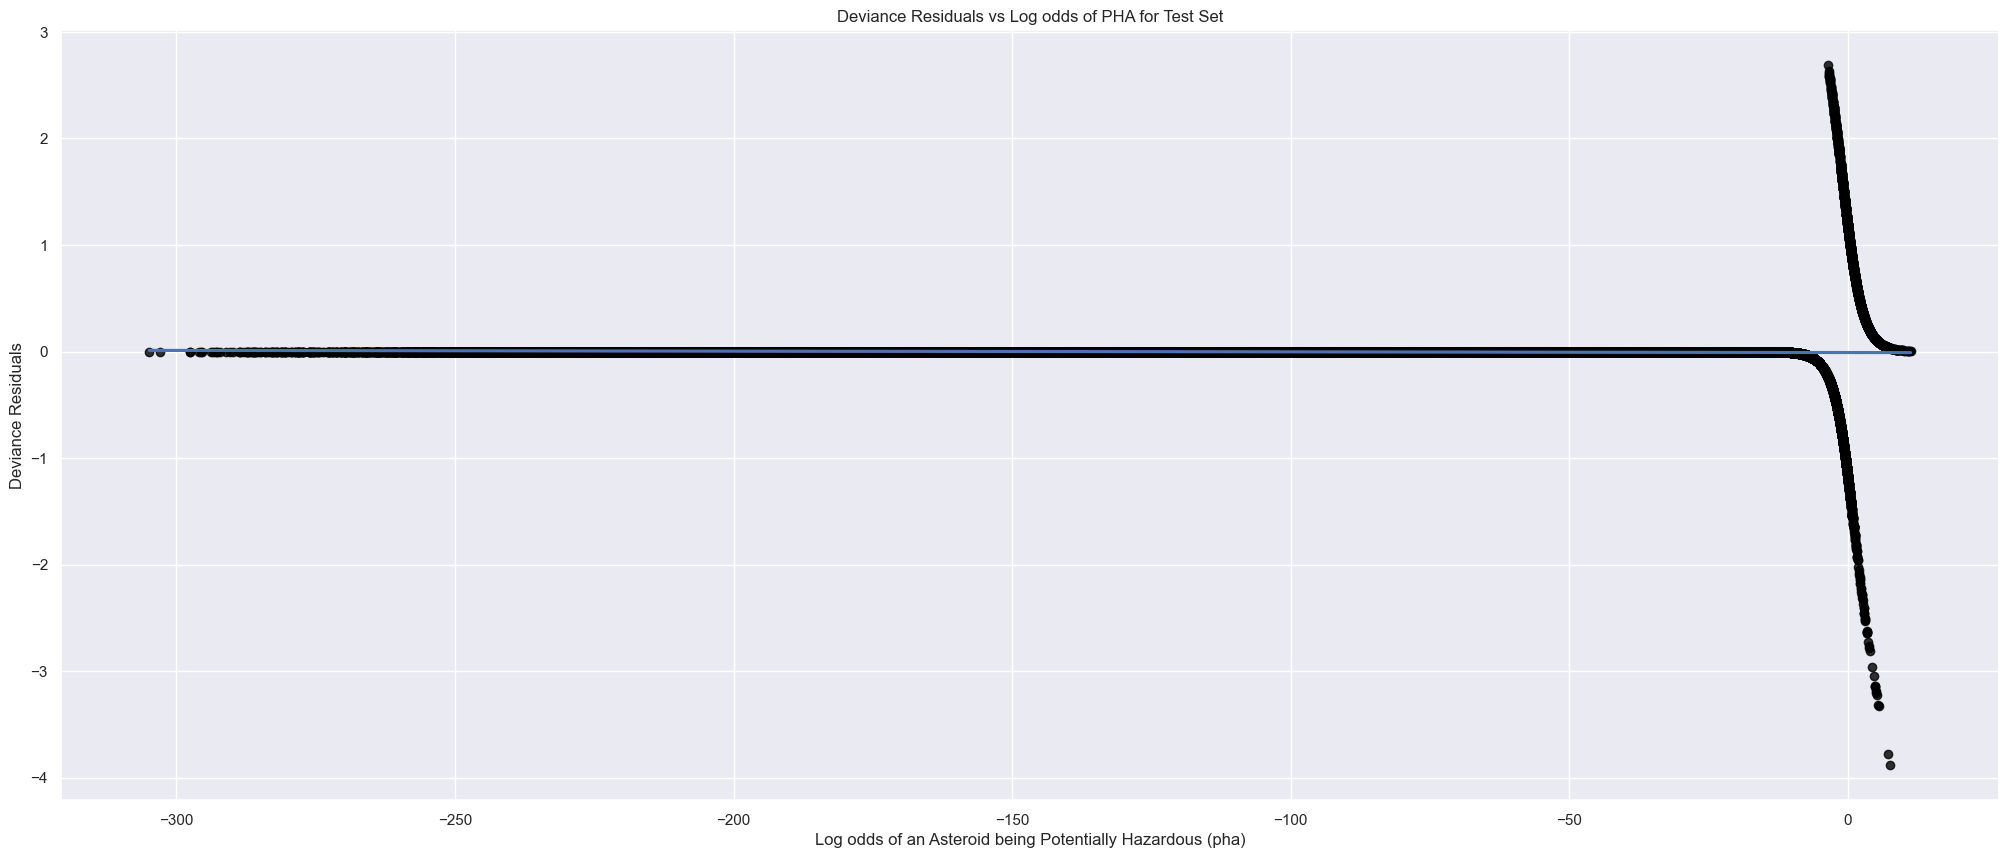

In [65]:
sns.regplot(x = model.fittedvalues, y = model.resid_dev, color = "black", line_kws = {"color":"b"})
plt.xlabel('Log odds of an Asteroid being Potentially Hazardous (pha)')
plt.ylabel('Deviance Residuals')
plt.title('Deviance Residuals vs Log odds of PHA for Test Set')
plt.show()

Seeing that the line seems to be completely horizontal, it would appear that the answer to my first question is that there is a linear relationship between the log odds of an asteroid being potentially hazardous and the three predictor variables used for the model.

The McFadden's pseudo r-squared is a measure of model fit. The higher the value, the better the model fit. For this logistic model the pseudo r-squared is 0.8615, which is a relatively high pseudo r-squared indicating a fairly good model fit.

Now for the area under the curve.

In [37]:
asteroid_train["predictive_prob"] = model.predict(asteroid_train)

In [38]:
auc = roc_auc_score(y_true=asteroid_train['dummy_pha'], y_score=asteroid_train['predictive_prob'])
auc

0.9996757579209975

The ROC curve is a graph/curve that shows the performance of a classification model at all classification thresholds. The AUC is the area under the ROC curve that is a measure of the performance of the logistic regression model classifier across all possible classification thresholds. AUC values range from 0 to 1 and the higher the value, the better the model. The AUC for this model is 0.9997 which is really high, indicating that this is a good model, predicting the pha status of the majority of the observations in the training dataset correctly.

In terms of the type of error that I might want to minimize, I would want to minimze the false negative rate because it would be worse if the model predicted that an asteroid isn't potentially hazardous (y-hat = 0) when it reality it is (y = 1). The asteroid would go unmonitored when it could in fact pose a threat to Earth in the future which we wouldn't be as prepared for. A false positive isn't as bad because further data and characteristics of the asteroid could be discovered to prove that the asteroid isn't potentially hazardous and doesn't need to be monitored.

Declaring the function to graph a ROC curve for the model.

In [39]:
def plot_roc(fpr, tpr, auc, lw=2):
    plt.plot(fpr, tpr, color='darkorange', lw=lw,
             label='ROC curve (area = '+str(round(auc,3))+')')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

Getting the false positive and true positive rates for the ROC curve.

In [40]:
fprs, tprs, thresholds = roc_curve(y_true=asteroid_train['dummy_pha'], y_score=asteroid_train['predictive_prob'])
pd.DataFrame({'fpr': fprs, 'tpr': tprs})

,fpr,tpr
0,0.000000,0.000000
1,0.000000,0.000609
2,0.000000,0.027389
3,0.000001,0.027389
4,0.000001,0.035301
...,...,...
983,0.002916,0.998783
984,0.002916,0.999391
985,0.003122,0.999391
986,0.003122,1.000000


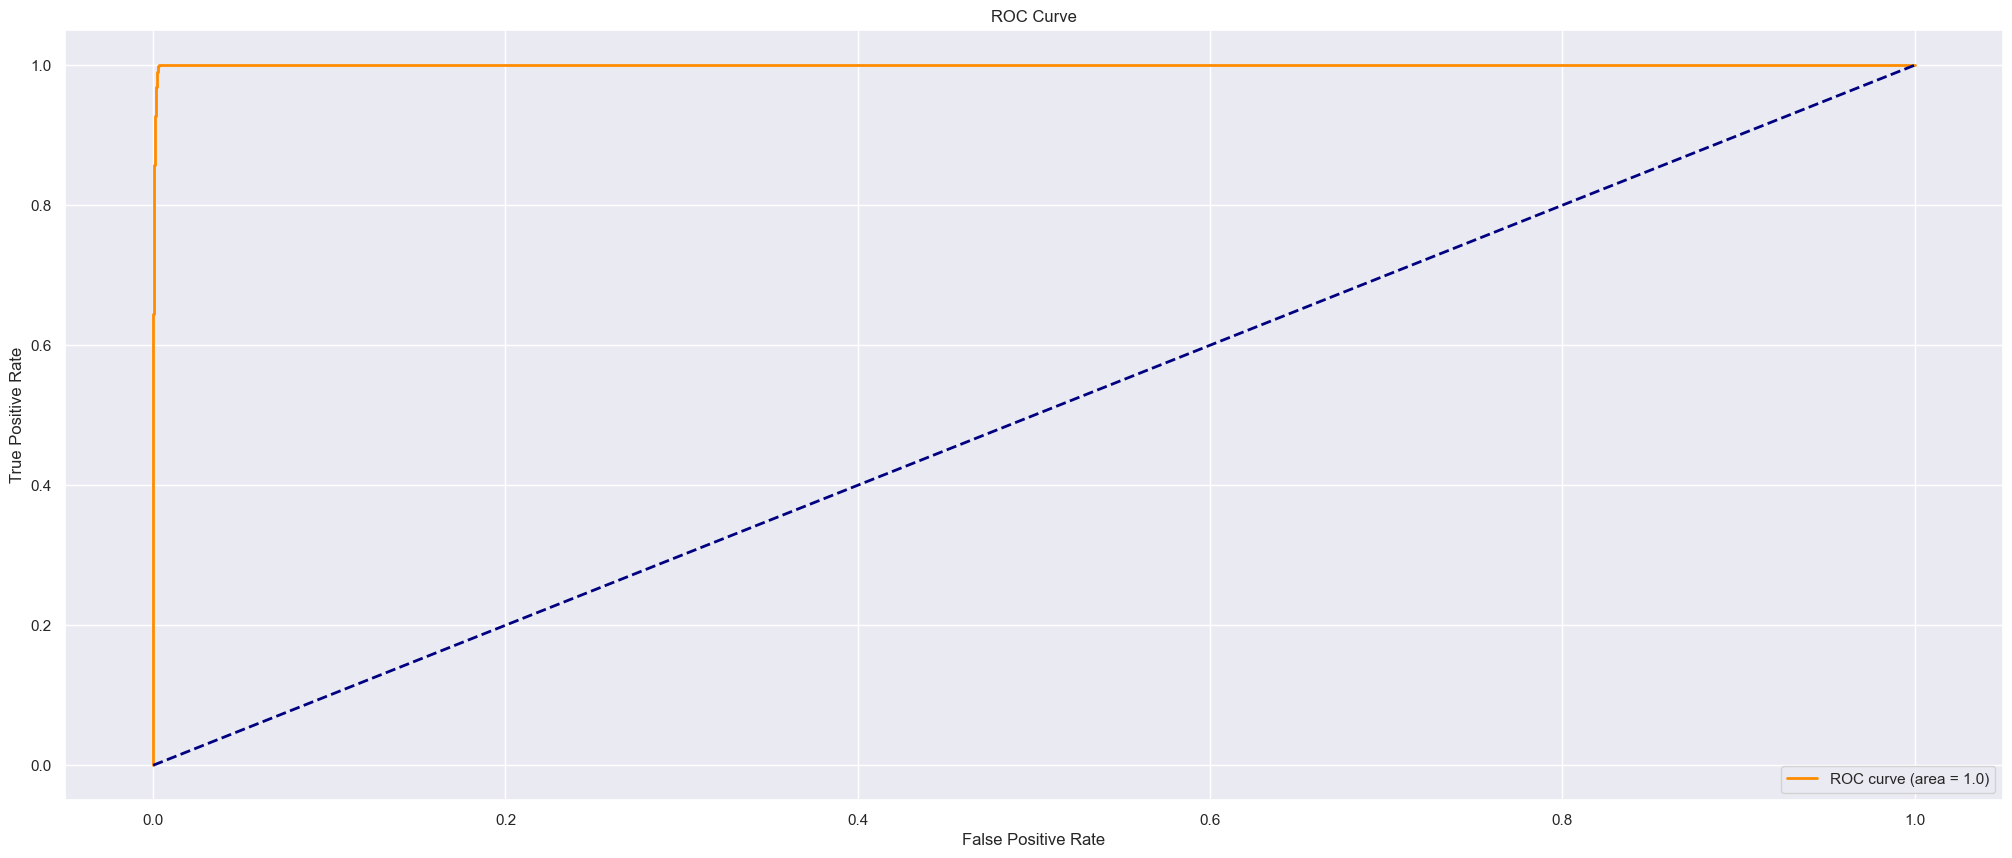

In [41]:
plot_roc(fprs, tprs, auc)

Declaring the function to list the various thresholds with their false positive and true positive rates.

In [42]:
def fpr_tpr_thresh(y, pred_prob, thresh):
    yhat = 1*(pred_prob >= thresh)
    tn, fp, fn, tp = confusion_matrix(y_true=y, y_pred=yhat).ravel()
    tpr = tp / (fn + tp)
    fpr = fp / (fp + tn)
    return pd.DataFrame({'threshold':[thresh],
                         'fpr':[fpr], 
                         'tpr':[tpr]})
for thresh in np.arange(0.02,0.03,.001):
    print(fpr_tpr_thresh(asteroid_train['dummy_pha'], asteroid_train['predictive_prob'], thresh))

   threshold       fpr  tpr
0       0.02  0.003567  1.0
   threshold       fpr  tpr
0      0.021  0.003499  1.0
   threshold      fpr  tpr
0      0.022  0.00342  1.0
   threshold       fpr  tpr
0      0.023  0.003357  1.0
   threshold       fpr  tpr
0      0.024  0.003292  1.0
   threshold       fpr  tpr
0      0.025  0.003238  1.0
   threshold       fpr  tpr
0      0.026  0.003176  1.0
   threshold       fpr       tpr
0      0.027  0.003122  0.999391
   threshold       fpr       tpr
0      0.028  0.003074  0.999391
   threshold       fpr       tpr
0      0.029  0.003024  0.999391


Using the ROC curve and attempting the minimize the false negative rate or maximizing the true positive rate, I determined that the ideal predictive probability threshold is 0.026 with a true positive rate of 1 with a false positive rate of 0.003122. From the thresholds listed above, the threshold of 0.026 had a true positive rate of 1 with the lowest false positive rate of the listed thresholds.

I'll make a confusion matrix to get the accurate rate, sensitivity, and specificity of the classification.

In [43]:
asteroid_train['y_hat'] = 1*(asteroid_train['predictive_prob']>=0.026)
tn, fp, fn, tp =confusion_matrix(y_true=asteroid_train['dummy_pha'], y_pred=asteroid_train['y_hat']).ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
accuracy = (tn+tp)/(tn+tp+fn+fp)
print('Accuracy:', accuracy)
print('Sensitivity (TPR):', sensitivity)
print('Specificity (TNR):', specificity)

Accuracy: 0.9968307142236132
Sensitivity (TPR): 1.0
Specificity (TNR): 0.9968236247166382


The accuracy rate is 0.9968. The sensitivity or true positive rate is 1. The specificity or the true negative rate is 0.9968.

Now to see how the model performs on new data that it hasn't seen before, the test dataset.

In [44]:
asteroid_test["predictive_prob"] = model.predict(asteroid_test)

In [45]:
auc = roc_auc_score(y_true=asteroid_test['dummy_pha'], y_score=asteroid_test['predictive_prob'])
auc

0.9997112559286877

Listing the various thresholds with their false positive and true positive rates for the predictions using the testing data. 

In [46]:
for thresh in np.arange(0.03,0.04,.001):
    print(fpr_tpr_thresh(asteroid_test['dummy_pha'], asteroid_test['predictive_prob'], thresh))

   threshold       fpr  tpr
0       0.03  0.002892  1.0
   threshold       fpr  tpr
0      0.031  0.002854  1.0
   threshold       fpr      tpr
0      0.032  0.002816  0.99763
   threshold       fpr      tpr
0      0.033  0.002789  0.99763
   threshold       fpr      tpr
0      0.034  0.002761  0.99763


   threshold       fpr      tpr
0      0.035  0.002718  0.99763
   threshold      fpr      tpr
0      0.036  0.00268  0.99763
   threshold       fpr      tpr
0      0.037  0.002658  0.99763
   threshold       fpr      tpr
0      0.038  0.002614  0.99763
   threshold       fpr      tpr
0      0.039  0.002571  0.99763
   threshold       fpr      tpr
0       0.04  0.002543  0.99763


Using the ROC curve and attempting the minimize the false negative rate or maximizing the true positive rate, I determined that the ideal predictive probability threshold is 0.031 with a true positive rate of 1 with a false positive rate of 0.002854. From the thresholds listed above, the threshold of 0.002854 had a true positive rate of 1 with the lowest false positive rate of the listed thresholds.

In [47]:
asteroid_test['y_hat'] = 1*(asteroid_test['predictive_prob']>=0.031)
tn, fp, fn, tp =confusion_matrix(y_true=asteroid_test['dummy_pha'], y_pred=asteroid_test['y_hat']).ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
accuracy = (tn+tp)/(tn+tp+fn+fp)
print('Accuracy:', accuracy)
print('Sensitivity (TPR):', sensitivity)
print('Specificity (TNR):', specificity)

Accuracy: 0.9971526845728755
Sensitivity (TPR): 1.0
Specificity (TNR): 0.9971461404817794


Given that the accurate rate, sensitivity, specificity, pseudo r-squared, and auc of the training data model were all high, I'm very happy with the performance of the current classifier. The accuracy rate, specificity, and auc of the testing data model was even higher than that of the training data model which I'm very satisfied with. To conclude and answer the second research question, the model performs quite well on new data, fitting the testing data better than that of the training data, surprisingly.

## 4. Conclusion

In conclusion, to briefly summarize the results, we found that the relationship between absolute magnitude aftering controlling for eccentricity, perihelion distance, and semi-major axis length was a linear moderately strong, negative one. Using the RMSE to determine how well a model performs on a new set of data, we also determined that the linear model performs well on data that it hasn't seen before as the training data RMSE was around 1.321 while the testing data RMSE was around 1.323 which is slightly better than the training data. One specific limitation to the linear model would be that the no multicollinearity assumption was not met. There was an extremely promiment relationship between perihelion distance and moid. This could cause the slope coefficients of the model to be unreliable. For the second set of questions, we found that there was a linear relationship between the log odds of an asteroids being potentially hazardous and the three predictor variables, absolute magnitude, eccentricity, and moid, combined through the fitted vs deviance residual plot made showing a completely horizontal line going through a deviance residual of zero. Using the accuracy rate to determine how well the classifier built on the logistic model performs on data that it hasn't seen before, a predictive probability threshold at 0.026 on the training data to minimize the false negative rate/maximize the true positive rate yielded an accuracy rate of 0.9968. Using predictive probability threshold at 0.031 on the testing data to minimize the false negative rate/maximize the true positive rate yielded an accuracy 0.9971 which is slightly better than that of the optimized threshold for the training data. This means the classifier performs well on new data.

As for limitations, not all identified asteroids are used in the dataset but I'm assuming that the cleaned dataset of over 900,000 asteroids is fairly representative of all asteroids in the solar system in regards to the characteristics that were used in this project. Another limitation is that we may never truly know how many asteroids are in the solar system exactly because of various difficulties such as in defining the boundaries of the solar system or what constitutes an asteroid, keeping track of the entry and departure of asteroids to or from the solar system with time, or in finding and tracking every last asteroid. The population of asteroids in the solar system should be a definite number, just one that no one might ever know, so the population median of all asteroids in the solar system similarly might not ever be found, meaning that I'll probably have no way of checking to see if my confidence interval is actually accurate. Even still, the population of all asteroids discovered by humanity is constantly increasing, so maybe one day the value of that population parameter may be found. These conclusions could help astronomers and astrophysicists better identify asteroids that are potentially hazardous which are catalogued in the future. In regards to future work, more inference could definitely be done with the multitude of other variables that I didn't use in this project and other people could use the conclusions drawn from this project to create more informed and meaningful research questions to analyze.